In [1]:
### Se importan las librerias
import os 
import pandas as pd
import numpy as np
import pickle
from numpy import exp
import sys
sys.path.append('libreriasTesis')
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.tsa.api import VAR
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from IPython.display import clear_output, Image, display
### Se asingan los paths
pathTesis = os.getcwd()
pathBases = os.path.join(pathTesis,'bases/ndatos')
pathGraficas = os.path.join(pathTesis,'GraficasN')
pathForec = os.path.join(pathTesis,'bases/forecast')
pathTables = os.path.join(pathTesis,'tables')

C:\ccastro\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
year_t=2017
year_t_1=2016

In [3]:
### Se lee la data y se cambian los nombres
dataTotalC = pd.read_csv(os.path.join(pathBases,str(year_t)+'data.csv'), sep='|',index_col=['Fecha'], parse_dates=True)

In [4]:
##Drop nans column
dataTotal=dataTotalC.dropna(axis=1,how='all')
dataTotal=dataTotal.dropna(axis=0,how='any')

In [5]:
display(dataTotal.head())
print("dimension:{}".format(dataTotal.shape))

,0.004,0.1,0.3,0.5,1.8,1.9,2.7,3.6,5.3,7.6,9.7,11.3,13.7,15.5
Fecha,,,,,,,,,,,,,,
2017-01-11,7.141,7.075,6.869,6.550,6.33,5.98,6.27,6.44,6.45,6.78,6.88,6.92,7.02,6.99
2017-01-12,7.140,7.068,6.827,6.522,6.28,5.96,6.21,6.39,6.42,6.71,6.79,6.88,6.95,6.98
2017-01-13,7.135,7.050,6.825,6.522,6.35,6.02,6.27,6.47,6.48,6.77,6.86,6.95,7.01,7.06
2017-01-14,7.135,7.050,6.825,6.522,6.35,6.02,6.27,6.47,6.48,6.77,6.86,6.95,7.01,7.06
2017-01-15,7.135,7.050,6.825,6.522,6.35,6.02,6.27,6.47,6.48,6.77,6.86,6.95,7.01,7.06


dimension:(355, 14)


In [6]:
### Se Asignan los diccionarios corresponientes a la data
vencimientos=list(map(lambda x: float(x),list(dataTotal.columns.values)))
observadosY = dict(zip(dataTotal.columns, vencimientos))
### Segmentos
corto=4
mediano=10
cortoPlazoM=vencimientos[:corto]
medianoPlazoM=vencimientos[corto:mediano]
largoPlazoM=vencimientos[mediano:]
cortoPlazoY = dict(zip(dataTotal.columns[:corto], cortoPlazoM))
medianoPlazoY = dict(zip(dataTotal.columns[corto:mediano], medianoPlazoM))
largoPlazoY = dict(zip(dataTotal.columns[mediano:], largoPlazoM))
innerY = {'1.6':1.6, '8':8}

In [7]:
# Estimation
lm = LinearRegression()
lm_no_intercept=LinearRegression(fit_intercept=False) #include or remove the intercept

# Se empieza a calculcar por separado los factores corresponientes a los modelos clasicos, segmentado y fuertemente segmentado

# ----------------------------------------------

### Nelson Siegel Clasico

In [8]:
### Los factores del modelo clasico con un lambda de 0.0609
def g(term,lambDa = 0.0609):
    resultado = (1 - exp(-lambDa*term)) / (lambDa*term)
    return resultado
def h(term,lambDa = 0.0609):
    resultado = ((1 - exp(-lambDa*term)) / (lambDa*term)) - exp(-lambDa*term)
    return resultado

In [9]:
def NS_clasico(data,terms):
    ### Se calcula el vector para los distinitos vencimientos
    gNS = g(np.array(terms))
    hNS = h(np.array(terms)) 
    X = pd.DataFrame({'x2':gNS,'x3':hNS}).values
    NS_fit=lm.fit(X,data.values.transpose())
    coefs=np.concatenate((np.array(NS_fit.intercept_.tolist()),NS_fit.coef_[:,0],NS_fit.coef_[:,1]),axis=0).reshape((3,data.values.shape[0])).transpose()
    betas_NS = pd.DataFrame(coefs, index=data.index,columns=["a","b","c"])
    ### Yields Estimados In-sample
    fitted_yield_NS = pd.DataFrame(NS_fit.predict(X).transpose(), index=data.index,columns=data.columns)    
    #RMSE
    NS3 = (pd.DataFrame(np.sqrt((data.values - fitted_yield_NS.values)**2)).apply(np.mean,0)*100).values
    RMSE_NS3=pd.Series(NS3,index=data.columns)
    out=(betas_NS,fitted_yield_NS,RMSE_NS3)
    return out

In [10]:
(betas_NS,fitted_yield_NS,RMSE_NS3)=NS_clasico(dataTotal,vencimientos)

In [ ]:
betas_NS.head()

In [ ]:
fitted_yield_NS.head()

In [ ]:
#Observed Yields
dataTotal.head()

# ----------------------------------------------

In [11]:
#Segmented Models
factores_seg=["a^I","b^I","c^I","a^II","b^II","c^II","a^III","b^III","c^III"]

### Nelson Siegel Segmented Non-Smootheness, prefered habitat model Vayanos and Vila (2009)

In [12]:
def NS_seg_Phabit(data,terms,corto,mediano,factores_seg):
    ### Se calcula el vector para los distinitos vencimientos
    gNS = g(np.array(terms))
    hNS = h(np.array(terms)) 
    X = pd.DataFrame({'x2':gNS,'x3':hNS}).values
    NS_fit_corto=lm.fit(X[:corto,:],data.iloc[:,:corto].values.transpose())
    NS_fit_mediano=lm.fit(X[corto:mediano,:],data.iloc[:,corto:mediano].values.transpose())
    NS_fit_largo=lm.fit(X[mediano:,:],data.iloc[:,mediano:].values.transpose())
    coefs_corto=np.concatenate((np.array(NS_fit_corto.intercept_.tolist()),NS_fit_corto.coef_[:,0],NS_fit_corto.coef_[:,1]),axis=0).reshape((3,data.values.shape[0])).transpose()
    coefs_mediano=np.concatenate((np.array(NS_fit_mediano.intercept_.tolist()),NS_fit_mediano.coef_[:,0],NS_fit_mediano.coef_[:,1]),axis=0).reshape((3,data.values.shape[0])).transpose()
    coefs_largo=np.concatenate((np.array(NS_fit_largo.intercept_.tolist()),NS_fit_largo.coef_[:,0],NS_fit_largo.coef_[:,1]),axis=0).reshape((3,data.values.shape[0])).transpose()
    betas_NS_seg_nosmooth = pd.DataFrame(np.concatenate((coefs_corto,coefs_mediano,coefs_largo),axis=1), index=data.index,columns=factores_seg)    
    ### Yields Estimados In-sample
    fited_yield_seg_nosmooth=np.concatenate((NS_fit_corto.predict(X[:corto,:]).transpose(),NS_fit_mediano.predict(X[corto:mediano,:]).transpose(),NS_fit_largo.predict(X[mediano:,:]).transpose()),axis=1)
    fitted_yield_NS_seg_nosmooth = pd.DataFrame(fited_yield_seg_nosmooth, index=data.index,columns=data.columns)
    #RMSE
    NS3_seg_nosmooth = (pd.DataFrame(np.sqrt((data.values - fitted_yield_NS_seg_nosmooth.values)**2)).apply(np.mean,0)*100).values
    RMSE_NS3_seg_nosmooth=pd.Series(NS3_seg_nosmooth,index=data.columns)
    out=(betas_NS_seg_nosmooth,fitted_yield_NS_seg_nosmooth,RMSE_NS3_seg_nosmooth)
    return out    

In [13]:
(betas_NS_seg_nosmooth,fitted_yield_NS_seg_nosmooth,RMSE_NS3_seg_nosmooth)=NS_seg_Phabit(dataTotal,vencimientos,corto,mediano,factores_seg)

In [ ]:
betas_NS_seg_nosmooth.head()

In [ ]:
fitted_yield_NS_seg_nosmooth.head()

In [ ]:
#Observed Yields
dataTotal.head()

In [14]:
print("Number of observed terms:{}".format(fitted_yield_NS_seg_nosmooth.columns.size))
print("Number of factors:{}".format(betas_NS_seg_nosmooth.columns.size))

Number of observed terms:14
Number of factors:9


# ----------------------------------------------

## Knots for Segments

In [15]:
#Introduce unobservable inner knots
Uobknots=('1.6','8')
cortoPlazoY.update({'1.6':1.6})
medianoPlazoY.update(innerY)
largoPlazoY.update({'8':8})
#introduce external knots
innerY.update( {'0.004':0.004,'15.3':15.3} )
#generalize
#dataTotal.columns[0],dataTotal.columns[(dataTotal.columns.size-1)]
#vencimientos[0],vencimientos[(len(vencimientos)-1)]

In [16]:
vec0 = lambda x: list(np.repeat(0,x))

### Nelson Siegel Segmented, impose smoothness by restrictions on the estimated coefficients

In [17]:
### Se crean las funciones de los factores y sus derivadas de nelson y siegel para el modelo Segmentado suave
def g(term,lambDa = 0.0609):
    resultado = (1 - exp(-lambDa*term)) / (lambDa*term)
    return resultado

def gPD(term,lambDa = 0.0609):
    resultado = (exp(-lambDa*term) * (lambDa*term + 1)) / (lambDa*(term ** 2))
    return resultado

def gSD(term,lambDa = 0.0609):
    resultado = (2 - exp(-lambDa*term) * (((lambDa * term) ** 2) + 2*(lambDa*term + 1))) / (lambDa * (term ** 3))
    return resultado 

def h(term,lambDa = 0.0609):
    resultado = ((1 - exp(-lambDa*term)) / (lambDa*term)) - exp(-lambDa*term)
    return resultado

def hPD(term,lambDa = 0.0609):
    resultado = (exp(-lambDa*term) * (((lambDa*term) ** 2) + (lambDa*term) + 1) - 1) / (lambDa*(term ** 2))
    return resultado

def hSD(term,lambDa = 0.0609):
    resultado = (2 - exp(-lambDa*term)*(((lambDa*term) ** 3) + ((lambDa*term) ** 2) + 2*(lambDa*term + 1))) / (lambDa * (term ** 3))
    return resultado


### Se crea la funcion X que permite retornar los vector de longitud 3 para la creacion de las matrices necesarias 
### del modelo segmentado


def X_function(tao,corte,signo,derivada):
    if derivada == '':
        if signo == '+':
            if corte == 'Corto':
                return [1, g(cortoPlazoY[tao]),h(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [1, g(medianoPlazoY[tao]),h(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [1, g(largoPlazoY[tao]),h(largoPlazoY[tao])]
        elif signo == '-':
            if corte == 'Corto':
                return [-1, -g(cortoPlazoY[tao]),-h(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [-1, -g(medianoPlazoY[tao]),-h(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [-1, -g(largoPlazoY[tao]),-h(largoPlazoY[tao])]
    elif derivada == 'PD':
        if signo == '+':
            if corte == 'Corto':
                return [0, gPD(cortoPlazoY[tao]),hPD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, gPD(medianoPlazoY[tao]),hPD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, gPD(largoPlazoY[tao]),hPD(largoPlazoY[tao])]
        elif signo == '-':
            if corte == 'Corto':
                return [0, -gPD(cortoPlazoY[tao]),-hPD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, -gPD(medianoPlazoY[tao]),-hPD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, -gPD(largoPlazoY[tao]),-hPD(largoPlazoY[tao])]
    elif derivada == 'SD':
        if signo == '+':
            if corte == 'Corto':
                return [0, gSD(cortoPlazoY[tao]),hSD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, gSD(medianoPlazoY[tao]),hSD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, gSD(largoPlazoY[tao]),hSD(largoPlazoY[tao])]
        elif signo == '-':
            if corte == 'Corto':
                return [0, -gSD(cortoPlazoY[tao]),-hSD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, -gSD(medianoPlazoY[tao]),-hSD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, -gSD(largoPlazoY[tao]),-hSD(largoPlazoY[tao])]
            

#### Aplicacion empirica

De aqui en adelante se crean las matrices necesarias w2, w1, R1, R2 para la creacion de Z.
Lo unico que cambia son los vencimientos de w1 y w2 y los valores de los yields

In [18]:
#R1
#complete matrix 
#NOTE the first line in matrix can be modified refering to refear to the first observable yield 
#this implies also a change in R2
R1_c =  np.matrix([X_function('1.6','Corto','+','')+ X_function('1.6','Mediano','-',''),
                   vec0(3)+X_function('8','Mediano','+',''),
                   X_function('1.6','Corto','+','PD')+ X_function('1.6','Mediano','-','PD'),
                   vec0(3)+X_function('8','Mediano','+','PD'),
                   X_function('1.6','Corto','+','SD')+ X_function('1.6','Mediano','-','SD')])
#truncate to make symetric
R1=R1_c[:,0:(R1_c.shape[1]-1)]
print("dimension:{}".format(R1.shape))

dimension:(5, 5)


In [19]:
#R2
#complete matrix  
#NOTE that the last line in matrix is the only one refering to an last observable yield (important to change for different year)
R2_c =  np.matrix([X_function('1.6','Mediano','-','')+vec0(3),
                 X_function('8','Mediano','+','')+ X_function('8','Largo','-',''),
                 X_function('1.6','Mediano','-','PD')+ vec0(3),
                 X_function('8','Mediano','+','PD')+ X_function('8','Largo','-','PD'),
                 X_function('1.6','Mediano','-','SD')+vec0(3)])
#truncate to make symetric
R2=R2_c[:,2:]
print("dimension:{}".format(R2.shape))

dimension:(5, 4)


In [20]:
#W matrix complete
W =  np.matrix([X_function('0.004','Corto','+','')+vec0(6),
                X_function('0.1','Corto','+','')+vec0(6),
                X_function('0.3','Corto','+','')+vec0(6),
                X_function('0.5','Corto','+','')+vec0(6),
                vec0(3) + X_function('1.8','Mediano','+','')+vec0(3),
                vec0(3) + X_function('1.9','Mediano','+','')+vec0(3),
                vec0(3) + X_function('2.7','Mediano','+','')+vec0(3),
                vec0(3) + X_function('3.6','Mediano','+','')+vec0(3),
                vec0(3) + X_function('5.3','Mediano','+','')+vec0(3),
                vec0(3) + X_function('7.6','Mediano','+','')+vec0(3),
                vec0(6) + X_function('9.7','Largo','+',''),
                vec0(6) + X_function('11.3','Largo','+',''),
                vec0(6) + X_function('13.7','Largo','+',''),
                vec0(6) + X_function('15.5','Largo','+','')])
print("dimension W:{}".format(W.shape))
W2=W[:,0:5]
print("dimension W2:{}".format(W2.shape))
W1=W[:,5:W.shape[1]]
print("dimension W1:{}".format(W1.shape))

dimension W:(14, 9)
dimension W2:(14, 5)
dimension W1:(14, 4)


In [21]:
#W matrix complete for estimating the unobserved yields
Wk =  np.matrix([X_function('1.6','Corto','+','')+vec0(6),
                vec0(3) + X_function('8','Mediano','+','')+vec0(3)])
#Wk =  np.matrix([vec0(3) + X_function('1.6','Mediano','+','')+vec0(3),
#                vec0(6) + X_function('8','Largo','+','')])
print("dimension W knots:{}".format(Wk.shape))
W2k=Wk[:,0:5]
print("dimension W2k:{}".format(W2k.shape))
W1k=Wk[:,5:W.shape[1]]
print("dimension W1k:{}".format(W1k.shape))

dimension W knots:(2, 9)
dimension W2k:(2, 5)
dimension W1k:(2, 4)


In [22]:
def NS_seg_weak(data,corto,mediano,R1,R2,W1,W2,W1k,W2k,factores_seg,Uobknots):
    R1_invertida = np.linalg.inv(R1)
    Z = W1 - (W2 * R1_invertida * R2)
    #print("dimension Z:{}".format(Z.shape))
    #estimation of the restricted factors for "c^II","a^III","b^III","c^III"
    NS_Seg_M_L=lm_no_intercept.fit(Z,data.values.transpose())
    #use equation from the paper to obtain factors #"a^I","b^I","c^I","a^II","b^II"
    coefs_S_M=(-R1_invertida*R2*NS_Seg_M_L.coef_.transpose()).transpose()
    betas_NS_seg_smooth = pd.DataFrame(np.concatenate((coefs_S_M,NS_Seg_M_L.coef_),axis=1), index=data.index,columns=factores_seg)
    ### Yields Estimados In-sample
    fitted_yield_NS_seg_smooth_z = pd.DataFrame(NS_Seg_M_L.predict(Z).transpose(), index=data.index,columns=data.columns)
    #RMSE
    NS3_seg_smooth = (pd.DataFrame(np.sqrt((data.values - fitted_yield_NS_seg_smooth_z.values)**2)).apply(np.mean,0)*100).values
    RMSE_NS3_seg_smooth=pd.Series(NS3_seg_smooth,index=data.columns)
    #Latent Yields
    Zk = W1k - (W2k * R1_invertida * R2)
    #print("dimension Z knots:{}".format(Zk.shape))
    ZZ_invertida = np.linalg.inv(Z.transpose()*Z)
    fit_yield_latent=(Zk*ZZ_invertida*Z.transpose()*data.values.transpose()).transpose()
    fitted_yield_latent = pd.DataFrame(fit_yield_latent, index=data.index,columns=Uobknots)
    #Add Latent Yields
    short=fitted_yield_NS_seg_smooth_z.iloc[:,:corto]
    knotSM=fitted_yield_latent.iloc[:,0]
    medium=fitted_yield_NS_seg_smooth_z.iloc[:,corto:mediano]
    knotML=fitted_yield_latent.iloc[:,1]
    long=fitted_yield_NS_seg_smooth_z.iloc[:,mediano:]
    frames = [short, knotSM, medium,knotML,long]
    fitted_yields_NS_seg_weak= pd.concat(frames,axis=1)
    out=(betas_NS_seg_smooth,fitted_yields_NS_seg_weak,RMSE_NS3_seg_smooth)
    return out       

In [23]:
(betas_NS_seg_smooth,fitted_yield_NS_seg_weak,RMSE_NS3_seg_smooth)=NS_seg_weak(dataTotal,corto,mediano,R1,R2,W1,W2,W1k,W2k,factores_seg,Uobknots)

In [ ]:
betas_NS_seg_smooth.head()

In [ ]:
#Observed Yields
dataTotal.head()

In [ ]:
fitted_yield_NS_seg_weak.head()

# ----------------------------------------------

## Nelson Siegel Strongly Segmented

In [24]:
### Se crean las funciones de los factores y sus derivadas de nelson y siegel para el modelo Segmentado Fuertemente
### Segmentado

def gs(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (1 - exp(-lambDa*A)) / (lambDa*A)
    return resultado

def gPDs(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (exp(-lambDa*A) * (lambDa*A + 1)) / (lambDa*(A ** 2))
    return resultado

def gSDs(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (2 - exp(-lambDa*A) * (((lambDa * A) ** 2) + 2*(lambDa*A + 1))) / (lambDa * (A ** 3))
    return resultado 

def hs(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = ((1 - exp(-lambDa*A)) / (lambDa*A)) - exp(-lambDa*A)
    return resultado

def hPDs(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (exp(-lambDa*A) * (((lambDa*A) ** 2) + (lambDa*A) + 1) - 1) / (lambDa*(A ** 2))
    return resultado

def hSDs(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (2 - exp(-lambDa*A)*(((lambDa*A) ** 3) + ((lambDa*A) ** 2) + 2*(lambDa*A + 1))) / (lambDa * (A ** 3))
    return resultado


### Se crea la funcion X que permite retornar los vector de longitud 3 para la creacion de las matrices necesarias 
### del modelo fuertemente segmentado

def Xs_function(tao,taoImenos,corte,signo,derivada):
    if derivada == '':
        if signo == '+':
            if corte == 'Corto':
                return [1, gs(cortoPlazoY[tao],cortoPlazoY[taoImenos]),hs(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                return [1, gs(medianoPlazoY[tao],medianoPlazoY[taoImenos]),hs(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                return [1, gs(largoPlazoY[tao],largoPlazoY[taoImenos]),hs(largoPlazoY[tao],largoPlazoY[taoImenos])]
        elif signo == '-':
            if corte == 'Corto':
                return [-1, -gs(cortoPlazoY[tao],cortoPlazoY[taoImenos]),-hs(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                return [-1, -gs(medianoPlazoY[tao],medianoPlazoY[taoImenos]),-hs(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                return [-1, -gs(largoPlazoY[tao],largoPlazoY[taoImenos]),-hs(largoPlazoY[tao],largoPlazoY[taoImenos])]
    elif derivada == 'PD':
        if signo == '+':
            if corte == 'Corto':
                return [0, gPDs(cortoPlazoY[tao],cortoPlazoY[taoImenos]),hPDs(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                return [0, gPDs(medianoPlazoY[tao],medianoPlazoY[taoImenos]),hPDs(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                return [0, gPDs(largoPlazoY[tao],largoPlazoY[taoImenos]),hPDs(largoPlazoY[tao],largoPlazoY[taoImenos])]
        elif signo == '-':
            if corte == 'Corto':
                return [0, -gPDs(cortoPlazoY[tao],cortoPlazoY[taoImenos]),-hPDs(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                return [0, -gPDs(medianoPlazoY[tao],medianoPlazoY[taoImenos]),-hPDs(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                return [0, -gPDs(largoPlazoY[tao],largoPlazoY[taoImenos]),-hPDs(largoPlazoY[tao],largoPlazoY[taoImenos])]
    elif derivada == 'SD':
        if signo == '+':
            if corte == 'Corto':
                return [0, gSDs(cortoPlazoY[tao],cortoPlazoY[taoImenos]),hSDs(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                return [0, gSDs(medianoPlazoY[tao],medianoPlazoY[taoImenos]),hSDs(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                return [0, gSDs(largoPlazoY[tao],largoPlazoY[taoImenos]),hSDs(largoPlazoY[tao],largoPlazoY[taoImenos])]
        elif signo == '-':
            if corte == 'Corto':
                return [0, -gSDs(cortoPlazoY[tao],cortoPlazoY[taoImenos]),-hSDs(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                return [0, -gSDs(medianoPlazoY[tao],medianoPlazoY[taoImenos]),-hSDs(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                return [0, -gSDs(largoPlazoY[tao],largoPlazoY[taoImenos]),-hSDs(largoPlazoY[tao],largoPlazoY[taoImenos])]

#### Aplicacion empirica

De aqui en adelante se crean las matrices necesarias w2, w1, R1, R2 para la creacion de Z.
Lo unico que cambia son los vencimientos de w1 y w2 y los valores de los yields

In [25]:
#R1
#complete matrix 
#NOTE the first line in matrix can be modified refering to refear to the first observable yield 
#this implies also a change in R2
R1_c =  np.matrix([Xs_function('1.6','0.004','Corto','+','')+ Xs_function('1.6','1.6','Mediano','-',''),
                   vec0(3)+Xs_function('8','1.6','Mediano','+',''),
                   Xs_function('1.6','0.004','Corto','+','PD')+ Xs_function('1.6','1.6','Mediano','-','PD'),
                   vec0(3)+Xs_function('8','1.6','Mediano','+','PD'),
                   Xs_function('1.6','0.004','Corto','+','SD')+ Xs_function('1.6','1.6','Mediano','-','SD')])
#truncate to make symetric
R1=R1_c[:,0:(R1_c.shape[1]-1)]
R1_invertida = np.linalg.inv(R1)
print("dimension:{}".format(R1.shape))

dimension:(5, 5)


In [26]:
#R2
#complete matrix  
#NOTE that the last line in matrix is the only one refering to an last observable yield (important to change for different year)
R2_c =  np.matrix([Xs_function('1.6','1.6','Mediano','-','')+vec0(3),
                 Xs_function('8','1.6','Mediano','+','')+ Xs_function('8','8','Largo','-',''),
                 Xs_function('1.6','1.6','Mediano','-','PD')+ vec0(3),
                 Xs_function('8','1.6','Mediano','+','PD')+ Xs_function('8','8','Largo','-','PD'),
                 Xs_function('1.6','1.6','Mediano','-','SD')+vec0(3)])
#truncate to make symetric
R2=R2_c[:,2:]
print("dimension:{}".format(R2.shape))

dimension:(5, 4)


In [27]:
#W matrix complete
W =  np.matrix([X_function('0.004','Corto','+','')+vec0(6),
                X_function('0.1','Corto','+','')+vec0(6),
                X_function('0.3','Corto','+','')+vec0(6),
                X_function('0.5','Corto','+','')+vec0(6),
                vec0(3) + X_function('1.8','Mediano','+','')+vec0(3),
                vec0(3) + X_function('1.9','Mediano','+','')+vec0(3),
                vec0(3) + X_function('2.7','Mediano','+','')+vec0(3),
                vec0(3) + X_function('3.6','Mediano','+','')+vec0(3),
                vec0(3) + X_function('5.3','Mediano','+','')+vec0(3),
                vec0(3) + X_function('7.6','Mediano','+','')+vec0(3),
                vec0(6) + X_function('9.7','Largo','+',''),
                vec0(6) + X_function('11.3','Largo','+',''),
                vec0(6) + X_function('13.7','Largo','+',''),
                vec0(6) + X_function('15.5','Largo','+','')])
print("dimension W:{}".format(W.shape))
W2=W[:,0:5]
print("dimension W2:{}".format(W2.shape))
W1=W[:,5:W.shape[1]]
print("dimension W1:{}".format(W1.shape))

dimension W:(14, 9)
dimension W2:(14, 5)
dimension W1:(14, 4)


In [28]:
#W matrix complete for estimating the unobserved yields
Wk =  np.matrix([Xs_function('1.6','0.004','Corto','+','')+vec0(6),
                vec0(3) + Xs_function('8','1.6','Mediano','+','')+vec0(3)])
#Wk =  np.matrix([vec0(3) + Xs_function('1.6','1.6','Mediano','+','')+vec0(3),
#                vec0(6) + Xs_function('8','8','Largo','+','')])
print("dimension W knots:{}".format(Wk.shape))
W2k=Wk[:,0:5]
print("dimension W2k:{}".format(W2k.shape))
W1k=Wk[:,5:W.shape[1]]
print("dimension W1k:{}".format(W1k.shape))

dimension W knots:(2, 9)
dimension W2k:(2, 5)
dimension W1k:(2, 4)


In [29]:
def NS_seg_strong(data,corto,mediano,R1,R2,W1,W2,W1k,W2k,factores_seg,Uobknots):
    R1_invertida = np.linalg.inv(R1)
    Z = W1 - (W2 * R1_invertida * R2)
    #estimation of the restricted factors for "c^II","a^III","b^III","c^III"
    NS_Seg_M_L=lm_no_intercept.fit(Z,data.values.transpose())
    #use equation from the paper to obtain factors #"a^I","b^I","c^I","a^II","b^II"
    coefs_S_M=(-R1_invertida*R2*NS_Seg_M_L.coef_.transpose()).transpose()
    betas_NS_seg_smooth_s = pd.DataFrame(np.concatenate((coefs_S_M,NS_Seg_M_L.coef_),axis=1), index=data.index,columns=factores_seg)
    ### Yields Estimados In-sample
    fitted_yield_NS_seg_smooth_s_z = pd.DataFrame(NS_Seg_M_L.predict(Z).transpose(), index=data.index,columns=data.columns)
    #RMSE
    NS3_seg_smooth_s = (pd.DataFrame(np.sqrt((data.values - fitted_yield_NS_seg_smooth_s_z.values)**2)).apply(np.mean,0)*100).values
    RMSE_NS3_seg_smooth_s=pd.Series(NS3_seg_smooth_s,index=data.columns)
    Zk = W1k - (W2k * R1_invertida * R2)
    #print("dimension Z knots:{}".format(Zk.shape))
    #Fitted latent yields
    ZZ_invertida = np.linalg.inv(Z.transpose()*Z)
    fit_yield_latent_s=(Zk*ZZ_invertida*Z.transpose()*data.values.transpose()).transpose()
    fitted_yield_latent_s = pd.DataFrame(fit_yield_latent_s, index=data.index,columns=Uobknots)
    #Add Latent Yields
    short=fitted_yield_NS_seg_smooth_s_z.iloc[:,:corto]
    knotSM=fitted_yield_latent_s.iloc[:,0]
    medium=fitted_yield_NS_seg_smooth_s_z.iloc[:,corto:mediano]
    knotML=fitted_yield_latent_s.iloc[:,1]
    long=fitted_yield_NS_seg_smooth_s_z.iloc[:,mediano:]
    frames = [short, knotSM, medium,knotML,long]
    fitted_yields_NS_seg_strong= pd.concat(frames,axis=1)
    out=(betas_NS_seg_smooth_s,fitted_yields_NS_seg_strong,RMSE_NS3_seg_smooth_s)
    return out 

In [30]:
(betas_NS_seg_smooth_s,fitted_yield_NS_seg_strong,RMSE_NS3_seg_smooth_s)=NS_seg_strong(dataTotal,corto,mediano,R1,R2,W1,W2,W1k,W2k,factores_seg,Uobknots)

In [ ]:
betas_NS_seg_smooth_s.head()

In [ ]:
#Observed Yields
dataTotal.head()

In [ ]:
fitted_yield_NS_seg_strong.head()

# ----------------------------------------------

# Graficas

### Loadings Segmentado

C:\ccastro\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ccastro\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


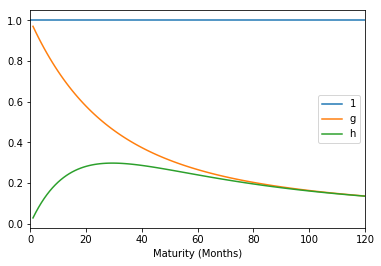

In [31]:
def gG(term,lambDa = 0.0609):
    resultado = (1 - exp(-lambDa*term)) / (lambDa*term)
    return resultado


def hG(term,lambDa = 0.0609):
    resultado = ((1 - exp(-lambDa*term)) / (lambDa*term)) - exp(-lambDa*term)
    return resultado

maturityPaper = np.array(range(0,121))
gValor = gG(maturityPaper)
hValor = hG(maturityPaper)
vec1 = list(np.repeat(1,len(maturityPaper)))
grafica2 = pd.DataFrame.from_dict({'1':vec1,'g':gValor,'h':hValor})
grafica2.plot()
plt.xlabel('Maturity (Months)')
plt.savefig(os.path.join(pathGraficas,'FactorLoadingsNS3'))
plt.show()

### Loadings Segmentado Fuertemente

C:\ccastro\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ccastro\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


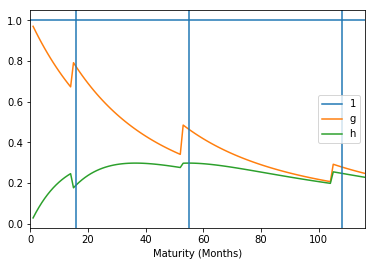

In [32]:
def gsG(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (1 - exp(-lambDa*A)) / (lambDa*A)
    return resultado

def hsG(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = ((1 - exp(-lambDa*A)) / (lambDa*A)) - exp(-lambDa*A)
    return resultado

maturityPaper1 = np.array(range(0,15))
maturityPaper2 = np.array(range(16,54))
maturityPaper3 = np.array(range(55,107))
maturityPaper4 = np.array(range(108,120))

gValor1 = gsG(maturityPaper1,0)
gValor2 = gsG(maturityPaper2,16)
gValor3 = gsG(maturityPaper3,55)
gValor4 = gsG(maturityPaper4,108)
gValor = np.append(np.append(gValor1,gValor2),np.append(gValor3,gValor4))

hValor1 = hsG(maturityPaper1,0)
hValor2 = hsG(maturityPaper2,16)
hValor3 = hsG(maturityPaper3,55)
hValor4 = hsG(maturityPaper4,108)
hValor = np.append(np.append(hValor1,hValor2),np.append(hValor3,hValor4))

vec1 = list(np.repeat(1,len(hValor)))

grafica2 = pd.DataFrame.from_dict({'1':vec1,'g':gValor,'h':hValor})
grafica2.plot()
plt.axvline(x=16)
plt.axvline(x=55)
plt.axvline(x=108)
plt.xlabel('Maturity (Months)')
plt.savefig(os.path.join(pathGraficas,'FactorLoadingsNS3Strong'))
plt.show()

### Observed Yields

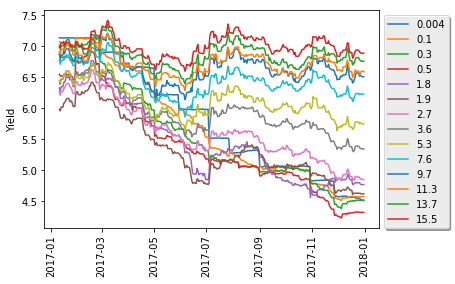

In [33]:
dataTotal.index.names = ['Date']
plt.ylabel('Yield')
ax = plt.subplot(111)
for col in dataTotal.columns:
    ax.plot(dataTotal.index,dataTotal.loc[:,col].values,label=col)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
plt.xticks(rotation='vertical')
plt.savefig(os.path.join(pathGraficas,'Observed yields'+str(year_t)),bbox_inches='tight')
plt.show()

### Modelo Segmentado (Fitted Yield)

In [34]:
#fitSegYields=fitted_yield_NS # Nelson & Siegel Clasico
#fitSegYields=fitted_yield_NS_seg_nosmooth # Prefered Habitat
#fitSegYields=fitted_yield_NS_seg_weak # Weakly Segmented
fitSegYields=fitted_yield_NS_seg_strong #Strongly Segmented

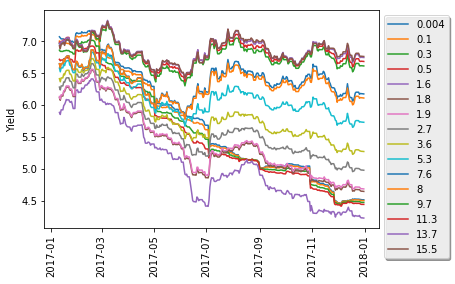

In [35]:
fitSegYields.index.names = ['Date']
plt.ylabel('Yield')
ax = plt.subplot(111)
for col in fitSegYields.columns:
    ax.plot(fitSegYields.index,fitSegYields.loc[:,col].values,label=col)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
plt.xticks(rotation='vertical')
plt.savefig(os.path.join(pathGraficas,'Fitted yields'+str(year_t)),bbox_inches='tight')
plt.show()

## RMSE entre NS3 y NS3 Segmented Fitted Yields

In [36]:
RMSE_tabl=pd.concat([RMSE_NS3,RMSE_NS3_seg_nosmooth,RMSE_NS3_seg_smooth,RMSE_NS3_seg_smooth_s],axis=1)
RMSE_tabl.columns= ['NS3', 'NS3_S', 'NS3_W_S','NS3_S_S'] 
RMSE_tabl.index.names = ['Maturity']

In [37]:
RMSE_tabl

,NS3,NS3_S,NS3_W_S,NS3_S_S
Maturity,,,,
0.004,31.936104,170.731387,24.665226,11.161556
0.1,20.302136,174.166908,14.333615,5.059548
0.3,5.598761,176.047007,5.028251,6.218089
0.5,15.180719,179.230071,16.659460,13.494339
1.8,21.450787,150.021178,13.985647,13.855668
1.9,34.777527,152.657295,26.254251,9.653362
2.7,16.195260,121.149874,6.247387,4.975720
3.6,7.429532,84.548630,15.741268,9.912951
5.3,6.830053,53.542967,6.794776,5.058669


In [38]:
RMSE_tabl.to_latex(index=False,bold_rows=True ,buf=os.path.join(pathTables,'RMSEInSample'+str(year_t)))

In [39]:
#Export betas for out-of-sample exercise keep only
#best performing in-sample: NS3 and NS3_S_S
betas_NS.to_csv(os.path.join(pathBases,'NS_'+str(year_t)+'.csv'), sep='|') # NS Classic Model
betas_NS_seg_smooth_s.to_csv(os.path.join(pathBases,'NS_S_'+str(year_t)+'.csv'), sep='|') # Strongly Segmented NS Model

## Out-of-Sample Forecasting for current year 

### Preparations

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [42]:
# Import estimated betas from prevoius year
# Use only best perfoming models
#Nelson and Siegel Classic
betas_NS_Y_1 = pd.read_csv(os.path.join(pathBases,'NS_'+str(year_t_1)+'.csv'), sep='|',index_col=['Date'], parse_dates=True)
# Strongly Segmented NS Model
betas_NS_seg_Y_1 = pd.read_csv(os.path.join(pathBases,'NS_S_'+str(year_t_1)+'.csv'), sep='|',index_col=['Date'], parse_dates=True)

In [43]:
#Factor Loadings NS Clasic
gNS = g(np.array(vencimientos))
hNS = h(np.array(vencimientos)) 
X = pd.DataFrame({'x1':np.ones_like(gNS),'x2':gNS,'x3':hNS}).values
#Factor Loadings NS Segmented
Z = W1 - (W2 * R1_invertida * R2)

## Out-of-Sample Forecasting (Rolling) choose only one of the models below

In [62]:
#Nelson and Siegel Classic
#Betas of previous year
betas_t_1=betas_NS_Y_1  
#Betas of current year
#Nelson and Siegel Classic
betas_t=betas_NS
# append
betas_FS=betas_t_1.append(betas_t)
#Type of model for forecasting functions
NS_model=0 

In [81]:
#Strongly Segmented NS Model
#Betas of previous year
betas_t_1=betas_NS_seg_Y_1 
#Betas of current year
betas_t=betas_NS_seg_smooth_s
#append
betas_FS=betas_t_1.append(betas_t)
#Type of model for forecasting functions
NS_model=1

In [82]:
#Define Estimation and evaluation window
lastObs_t_1=betas_t_1.shape[0]-1
WE=126 # estimation window (aprox 6 months of trading days)
WT=betas_t.shape[0]  #evaluation window
#Forecast horizon
horizon=21 #1 day, 5 days (week), 21 days (month), 63 days (3 months)
#Forecast Sample
betas_FS=betas_FS.iloc[((lastObs_t_1)-(WE-1)):,:]

In [83]:
def NS_yields_fore(Yields,betasS,horizon,WE,X,Z,NS_model):
    ErrEW = pd.DataFrame(columns=Yields.columns)
    for i in range(0,(Yields.shape[0]-horizon)):
        data=betasS.iloc[(0+i):(WE+i),:]
        betasout=pd.DataFrame(index=Yields.index[i:i+horizon],columns=data.columns)
        ObsYields=Yields.iloc[i:i+horizon,:]
        for col in data.columns:
            model = ARIMA(data.loc[:,col].values, order=(1,0,0))
            model_fit = model.fit(disp=0)
            betasout.loc[:,col]=model_fit.forecast(steps=horizon)[0]
        if NS_model==0:
            fitted_yield = pd.DataFrame(np.dot(X,betasout.values.transpose()).transpose(), index=ObsYields.index,columns=Yields.columns)
        else:
            fitted_yield = pd.DataFrame(np.dot(Z,betasout.iloc[:,5:].values.transpose()).transpose(), index=ObsYields.index,columns=Yields.columns)
        Err_yield=pd.DataFrame(ObsYields.values - fitted_yield.values, index=ObsYields.index,columns=Yields.columns)
        ErrEW=ErrEW.append(Err_yield.iloc[(horizon-1),:])
    return ErrEW

In [84]:
ErrEW=NS_yields_fore(dataTotal,betas_FS,horizon,WE,X,Z,NS_model)

C:\ccastro\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ccastro\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ccastro\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ccastro\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
C:\ccastro\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\ccastro\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).co

In [85]:
#RMSE
RMSE=np.sqrt(ErrEW.apply(lambda x: x**2).mean())
RMSE.to_csv(os.path.join(pathForec,'RMSE_'+str(NS_model)+'_H'+str(horizon)+'_'+str(year_t)+'.csv'), sep=';') 

## Benchmark Forecast with Random Walk Model

In [67]:
#Nelson and Siegel Classic or Strongly Segmented NS Model
#Betas of random walk
betas_RW_t=betas_t.shift(periods=horizon)  
#Betas of current year: betas_t
#Type of model for forecasting functions: NS_model=0 

In [68]:
def NS_yields_RW(Yields,betasRW,X,Z,NS_model):
    if NS_model==0:
        fitted_yield = pd.DataFrame(np.dot(X,betasRW.values.transpose()).transpose(), index=Yields.index,columns=Yields.columns)
    else:
        fitted_yield = pd.DataFrame(np.dot(Z,betaRW.iloc[:,5:].values.transpose()).transpose(), index=Yields.index,columns=Yields.columns)
    Err_yield=pd.DataFrame(Yields.values - fitted_yield.values, index=Yields.index,columns=Yields.columns)
    return Err_yield

In [69]:
ErrRW=NS_yields_RW(dataTotal,betas_RW_t,X,Z,NS_model)

In [70]:
#RMSE
RMSE_RW=np.sqrt(ErrRW.apply(lambda x: x**2).mean())
RMSE_RW.to_csv(os.path.join(pathForec,'RMSE_RW_H'+str(horizon)+'_'+str(year_t)+'.csv'), sep=';') 